# BBC - Laboratoire 4
## Alignement de séquences et arbres phylogénétiques

- Professeur: Xavier Brochet (<a href="mailto:xavier.brochet@heig-vd.ch">xavier.brochet@heig-vd.ch</a>)
- Assistant: Thibault Schowing (<a href="mailto:thibault.schowing@heig-vd.ch">thibault.schowing@heig-vd.ch</a>)
- Étudiant: Michael Strefeler

Date: Printemps 2025

> ## Objectifs pédagogiques
Pour réaliser ce laboratoire, du vocabulaire et des notions de base en biologie seront introduits ou perfectionnés (revoir Labo-1 si nécessaire). A la fin du laboratoire, l’étudiant devrait:
>- Etre à l’aise avec l’utilisation d’Entrez Direct pour accéder à Genbank.
>- Savoir utiliser des outils d’alignement de séquence, à l’aide du logiciel clustallOmega (ebi) Jaliview et avec la librairie biopython.
>- Savoir construire un arbre phylogénétique à partir d’un alignement et l’interpréter.


> ## But du labo
La septicémie hémorragique virale est une maladie très contagieuse et mortelle qui touche les poissons de type salmonidés (les humains ne sont pas touchés). Elle est causée par un virus qui engendre chaque année de grosses pertes économiques pour les pisciculteurs. Votre but est de visualiser comment le virus se propage dans le monde, en comparant les séquences de la protéine G (glycoprotéine se trouvant à la surface du virus) de plusieurs isolats.

> ## Démarche
>1. Visualisation de la présence du virus dans le monde (Genbank, Entrez Direct et biopython).
>2. Alignement des séquences protéiques pour pouvoir les comparer (MUSCLE, (ClustalW), Clustal Omega).
>3. Construction de l’arbre phylogénétique et clustering hiérarchique pour identifier des groupes d’isolats similaires.


> ## Rapport de labo

> <p >Merci de répondre aux questions posées sur fond bleu de façon concise dans la cellule située <u>juste en dessous</u>, et de nous retourner ce notebook.
> <p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>0. </b></font> Ceci est une question.</p>

## 1. Le virus dans le monde - visualisation d’isolats séquencés

Vous allez apprendre à utiliser certains outils à la fois en mode graphique et en mode ligne de commande.

Votre premier objectif est de récupérer sur Genbank la localisation géographique de toutes les souches séquencées du virus (protéine G uniquement) et de les visualiser sur une carte du monde.

<b>→ Depuis votre navigateur, allez sur le site de [Genbank](http://www.ncbi.nlm.nih.gov/genbank/) et dans la barre de recherche, tapez</b>: G[gene] AND VHSV[orgn] NOT "mRNA"[title] AND "complete cds"[title] AND "2020"[PDAT] 

Cette requête limite les recherches aux entrées dont le nom du gène s’intitule G, dont l’organisme est le VHSV (Viral Hemorrhagic Septicemia Virus), dont le titre ne contient pas le mot “mRNA” et dont la séquence est complète. Pour tricher un peu on sélectionne aussi la date de publication 2020. Vous pouvez retrouver la doc pour la syntaxe de recherche [ici](https://www.ncbi.nlm.nih.gov/Web/Search/query.txt).

<b>→ Cliquez sur la première entrée qui doit être: https://www.ncbi.nlm.nih.gov/nuccore/MN729317.1</b>

Dans la partie JOURNAL ainsi que la partie FEATURES - source, vous pouvez voir que le pays d’origine est France.

<b>→ Cliquez sur cette autre entrée: [http://www.ncbi.nlm.nih.gov/nuccore/341904092](http://www.ncbi.nlm.nih.gov/nuccore/341904092) </b>
Vous pouvez voir qu’en plus du pays qui est la Finlande, la latitude et la longitude sont également indiqués.

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.1 </b></font>Quelles sont les coordonnées (latitude, longitude) et pays d’origine de l’isolat dont l'ACCESSION=HQ112233 et gi=341904064 (attention le gi n'est officiellement plus utilisé)?</p>

<font color="orange"><b>On peut trouver l'isolat sur cette [page](https://www.ncbi.nlm.nih.gov/nuccore/341904064) web et sont ""61.01 N 18.30 E", c'est en Finlande (précisement [ici](https://www.google.com/maps/place/61.01+18.30))</b></font>

Votre recherche avec la requête initiale sans le tri sur l'année retourne 410 entrées (état en mars 2025). Afin de récupérer les données géographiques de tous les isolats, il vous faut avoir recours à un langage de script. Comme vu au Labo 2, nous ferons appel à Entrez Direct en utilisant la librairie biopython.

<b>→ Importez les modules suivants</b>

Pour un démarrage rapide, vous pouvez utiliser le code suivant pour importer les modules nécessaires et créer directement l'environnement. N'oubliez pas d'activer et d'installer ipykernel pour l'environnement bbc4 avec pip. 

```
conda create --name bbc4 conda-forge::biopython matplotlib numpy pandas basemap cartopy scipy
```



In [1]:
from Bio import Entrez
Entrez.email = "michael.strefeler@heig-vd.ch" # une adresse email valide est nécessaire

import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
import pickle # TBR
import os
import pandas as pd

%matplotlib inline

<b>→ Commencez par récupérer les identifiants gi correspondant à la requête en utilisant Entrez.esearch()</b>

In [2]:
query = 'G[gene] AND VHSV[orgn] NOT "mRNA"[title] AND "complete cds"[title]'
handle = Entrez.esearch(db='nucleotide',retmax=1000,term=query)
record = Entrez.read(handle)

print(record.keys())

gi = record['IdList']

# Print the list of GI numbers
print(gi)
print(len(gi))

dict_keys(['Count', 'RetMax', 'RetStart', 'IdList', 'TranslationSet', 'TranslationStack', 'QueryTranslation'])
['2742832285', '2742832283', '2742832281', '2742832279', '2742832277', '2742832275', '2742832273', '2742832271', '2666896523', '2666896516', '2666896509', '2666896502', '2666896495', '2666896488', '2666896481', '1852458931', '1852458929', '1852458927', '1852458925', '1686200771', '1526309610', '1526309608', '1270117903', '1270117901', '1270117899', '1270119027', '1270119025', '1270119023', '1149552508', '1149552506', '1149552504', '1149552502', '1149552500', '1149552498', '1149552496', '1149552494', '1149552492', '1149552490', '1149552488', '1149552486', '1149552484', '1149552482', '1149552480', '1149552478', '1149552476', '1149552474', '1149552472', '1149552470', '1149552468', '1149552466', '1149552464', '1149552462', '1149552460', '1149552458', '1149552456', '1149552454', '1149552452', '1149552450', '1149552448', '1149552446', '1149552444', '1149552442', '1149552440', '11495

In [3]:
# For a more up to date code, we fetch accession numbers for the retrieved IDs
if gi:
    fetch_handle = Entrez.efetch(db="nucleotide", id=",".join(gi), rettype="acc", retmode="text")
    accessions = fetch_handle.read().strip().split("\n")
    fetch_handle.close()
else:
    accessions = []

# Print retrieved accession numbers
print(accessions)
print(len(accessions))

['PP882718.1', 'PP882717.1', 'PP882716.1', 'PP882715.1', 'PP882714.1', 'PP882713.1', 'PP882712.1', 'PP882711.1', 'OQ417829.1', 'OQ417828.1', 'OQ417827.1', 'OQ417826.1', 'OQ417825.1', 'OQ417824.1', 'OQ417823.1', 'MN729317.1', 'MN729316.1', 'MN729315.1', 'MN729314.1', 'MG753786.2', 'MH836523.1', 'MH836522.1', 'MF176930.1', 'MF176929.1', 'MF176928.1', 'MF176927.1', 'MF176926.1', 'MF176925.1', 'KU728262.1', 'KU728261.1', 'KU728260.1', 'KU728259.1', 'KU728258.1', 'KU728257.1', 'KU728256.1', 'KU728255.1', 'KU728254.1', 'KU728253.1', 'KU728252.1', 'KU728251.1', 'KU728250.1', 'KU728249.1', 'KU728248.1', 'KU728247.1', 'KU728246.1', 'KU728245.1', 'KU728244.1', 'KU728243.1', 'KU728242.1', 'KU728241.1', 'KU728240.1', 'KU728239.1', 'KU728238.1', 'KU728237.1', 'KU728236.1', 'KU728235.1', 'KU728234.1', 'KU728233.1', 'KU728232.1', 'KU728231.1', 'KU728230.1', 'KU728229.1', 'KU728228.1', 'KU728227.1', 'KU728226.1', 'KU728225.1', 'KU728224.1', 'KU728223.1', 'KU728222.1', 'KU728221.1', 'KU728220.1', 'KU72

In [4]:
# Save gi list to a pickle file
with open('./data/gi_list.pkl', 'wb') as f:
    pickle.dump(gi, f)

→ Si vous n'arrivez pas à obtenir les identifiants gi avec Entrez.esearch() utilisez la commande suivante qui va lire le ficher contenant la liste des gi

In [5]:
# Read the gi list from the pickle file
#with open('./data/gi_list.pkl', 'rb') as f:
#    gi = pickle.load(f)


<b>→ Allez chercher les informations Genbank sur ces séquences en utilisant Entrez.efetch()</b>

In [6]:
# Get Entrez data for the list of 'gi'
protein_info_http  = Entrez.efetch(db="nucleotide",id=gi,rettype="gb",retmode="xml")

# Read raw XML data
#protein_data = protein_info_http.read()
protein_info = Entrez.read(protein_info_http)

# check the types of the data
print(type(protein_info_http))
print(type(protein_info))

<class 'http.client.HTTPResponse'>
<class 'Bio.Entrez.Parser.ListElement'>


In [7]:
# Save the raw XML data to a file
with open("./data/proteins_info.pkl", "wb") as outfile:
    pickle.dump(protein_info, outfile)

→ Si vous n'arrivez pas à obtenir les informations avec Entrez.esearch() utilisez la commande suivante qui va lire le fichier.

In [8]:
# Reopen and parse the saved XML file
#with open("./data/proteins_info.pkl", "rb") as infile:
#    protein_info = pickle.load(infile)

In [9]:
# Check the type of the data
print(len(protein_info))

410


<font face='courier'>protein_info</font> est une liste de 410 éléments. Chaque élément consiste en une structure de listes et dictionnaires contenant toute l’information de Genbank correpondant à la requête.

<b>→ Imprimez le 25ème élément de protein_info et quelques unes de ses caractéristiques.</b>


In [10]:
# Vous pouvez ajouter ce que vous voulez à ce code pour afficher les informations désirées

id = 25

print("--------------------")
print(f"Content of protein_info {id}")
print("--------------------")

for e in protein_info[id].keys():
    print(e)

print("")
print("--------------------")
print("GBSeq_feature-table details")
print("--------------------")

for e in protein_info[id]['GBSeq_feature-table'][0].keys():
    print(e)


# Pour l'élément "id" de la liste des protéines, afficher les éléments de la liste "GBSeq_feature-table", puis les détails ""
for e in protein_info[id]['GBSeq_feature-table']:
    print(e)
    print(f"\tFeature Quals: {e['GBFeature_quals']}")
    print("")


--------------------
Content of protein_info 25
--------------------
GBSeq_locus
GBSeq_length
GBSeq_strandedness
GBSeq_moltype
GBSeq_topology
GBSeq_division
GBSeq_update-date
GBSeq_create-date
GBSeq_definition
GBSeq_primary-accession
GBSeq_accession-version
GBSeq_other-seqids
GBSeq_source
GBSeq_organism
GBSeq_taxonomy
GBSeq_references
GBSeq_comment
GBSeq_feature-table
GBSeq_sequence

--------------------
GBSeq_feature-table details
--------------------
GBFeature_key
GBFeature_location
GBFeature_intervals
GBFeature_quals
{'GBFeature_key': 'source', 'GBFeature_location': '1..1568', 'GBFeature_intervals': [{'GBInterval_from': '1', 'GBInterval_to': '1568', 'GBInterval_accession': 'MF176927.1'}], 'GBFeature_quals': [{'GBQualifier_name': 'organism', 'GBQualifier_value': 'Viral hemorrhagic septicemia virus'}, {'GBQualifier_name': 'mol_type', 'GBQualifier_value': 'viral cRNA'}, {'GBQualifier_name': 'isolate', 'GBQualifier_value': 'Fi06.108RT'}, {'GBQualifier_name': 'host', 'GBQualifier_value':

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.2 </b></font> Quel est le pays d’origine du 25ème isolat dans notre liste?
</p>

<font color="orange"><b>La Finlande</b></font>

→ Pour extraire le pays automatiquement, faites une boucle sur les features jusqu’à tomber sur **geo_loc_name**:

In [11]:
for j,feat in enumerate(protein_info[25]['GBSeq_feature-table'][0]['GBFeature_quals']):
    print("Feature name: "+str(feat) + "  - j: "+ str(j))
    if feat['GBQualifier_name']=='geo_loc_name':
        print("Pays d'origine: "+feat['GBQualifier_value'].split(':')[0])

Feature name: {'GBQualifier_name': 'organism', 'GBQualifier_value': 'Viral hemorrhagic septicemia virus'}  - j: 0
Feature name: {'GBQualifier_name': 'mol_type', 'GBQualifier_value': 'viral cRNA'}  - j: 1
Feature name: {'GBQualifier_name': 'isolate', 'GBQualifier_value': 'Fi06.108RT'}  - j: 2
Feature name: {'GBQualifier_name': 'host', 'GBQualifier_value': 'Oncorhynchus mykiss'}  - j: 3
Feature name: {'GBQualifier_name': 'db_xref', 'GBQualifier_value': 'taxon:11287'}  - j: 4
Feature name: {'GBQualifier_name': 'geo_loc_name', 'GBQualifier_value': 'Finland'}  - j: 5
Pays d'origine: Finland
Feature name: {'GBQualifier_name': 'collection_date', 'GBQualifier_value': 'May-2006'}  - j: 6


<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.3 </b></font> Généralisez ce code pour qu’il imprime le pays d’origine des 410 isolats et enregistre le résultat dans une variable (liste de 410 éléments) appelée **country** (si le pays n’est pas disponible, ajoutez le texte ‘NA’ (not available) à la place).
    
    Exemple d'affichage:
    >- num | Pays d'origine: Iceland
    >- 1 | Pays d'origine: Denmark
</p>

In [12]:
country = []
for i, prot in enumerate(protein_info):
    features_quals = prot['GBSeq_feature-table'][0]['GBFeature_quals']
    found = False
    for feat in features_quals:
        if feat['GBQualifier_name'] == 'geo_loc_name':
            current_country = feat['GBQualifier_value'].split(':')[0]
            if len(current_country) == 0:
                current_country = 'NA'
            found = True
    if not found:
        current_country = 'NA'
    print(f"{str(i):3s} | Pays d'origine: {current_country}")
    country.append(current_country)

0   | Pays d'origine: South Korea
1   | Pays d'origine: South Korea
2   | Pays d'origine: South Korea
3   | Pays d'origine: South Korea
4   | Pays d'origine: South Korea
5   | Pays d'origine: South Korea
6   | Pays d'origine: South Korea
7   | Pays d'origine: South Korea
8   | Pays d'origine: South Korea
9   | Pays d'origine: South Korea
10  | Pays d'origine: South Korea
11  | Pays d'origine: South Korea
12  | Pays d'origine: South Korea
13  | Pays d'origine: South Korea
14  | Pays d'origine: South Korea
15  | Pays d'origine: France
16  | Pays d'origine: France
17  | Pays d'origine: France
18  | Pays d'origine: France
19  | Pays d'origine: Iran
20  | Pays d'origine: Iceland
21  | Pays d'origine: Iceland
22  | Pays d'origine: Finland
23  | Pays d'origine: Finland
24  | Pays d'origine: Finland
25  | Pays d'origine: Finland
26  | Pays d'origine: Finland
27  | Pays d'origine: Finland
28  | Pays d'origine: Denmark
29  | Pays d'origine: Denmark
30  | Pays d'origine: Denmark
31  | Pays d'orig

<b>→ Pour certains isolats, la latitude et la longitude sont également indiqués. Par exemple, exécutez:</b>


In [13]:
for i,prot in enumerate(protein_info):
    #print(f"Isolat {i}")
    # Vous pouvez ajouter ce que vous voulez à ce code pour afficher les informations désirées
    # et explorer les résultats. Commentez simplement les prints inutiles pour ne pas surcharger la sortie avant de rendre.
    features_quals = prot['GBSeq_feature-table'][0]['GBFeature_quals']
    
    for j,feat in enumerate(features_quals):
        #print("Feature name: "+str(feat) + "j: "+str(j))
        if feat['GBQualifier_name']=='lat_lon':
            print(f"Isolat {i} - feature {j} ")
            print("Latitude et longitude: "+ feat['GBQualifier_value'].split(':')[0])

Isolat 314 - feature 5 
Latitude et longitude: 60.29 N 21.29 E
Isolat 315 - feature 5 
Latitude et longitude: 60.24 N 22.06 E
Isolat 316 - feature 5 
Latitude et longitude: 60.29 N 21.29 E
Isolat 317 - feature 5 
Latitude et longitude: 60.26 N 22.05 E
Isolat 318 - feature 5 
Latitude et longitude: 60.26 N 22.05 E
Isolat 319 - feature 5 
Latitude et longitude: 60.26 N 22.05 E
Isolat 320 - feature 5 
Latitude et longitude: 60.34 N 21.44 E
Isolat 321 - feature 5 
Latitude et longitude: 60.27 N 21.56 E
Isolat 322 - feature 5 
Latitude et longitude: 60.27 N 21.56 E
Isolat 323 - feature 5 
Latitude et longitude: 60.26 N 22.06 E
Isolat 324 - feature 5 
Latitude et longitude: 60.26 N 22.06 E
Isolat 325 - feature 5 
Latitude et longitude: 60.26 N 22.06 E
Isolat 326 - feature 5 
Latitude et longitude: 60.26 N 22.06 E
Isolat 327 - feature 5 
Latitude et longitude: 60.26 N 22.06 E
Isolat 328 - feature 5 
Latitude et longitude: 60.26 N 22.06 E
Isolat 329 - feature 5 
Latitude et longitude: 61.01 N 

Par exemple pour l'isolat 314 on a, <font face='courier'>lat_lon = 60.29 N 21.29 E</font> (latitude 60.29°, longitude 21.29°).

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.4 </b></font>  Généralisez votre code pour qu’il enregistre aussi la latitude et la longitude dans deux variables séparées (mettez un <font face='courier'>float(‘nan’)</font> si elles ne sont pas disponibles). Astuce: Utilisez la fonction split(‘ ‘) pour extraire les nombres qui vous intéressent de lat_lon (à convertir en float aussi). 
</p>

In [14]:
country = []
lat = []
long = []


for i, prot in enumerate(protein_info):
    features_quals = prot['GBSeq_feature-table'][0]['GBFeature_quals']
    found_country = False
    found_lat_long = False
    for feat in features_quals:
        if feat['GBQualifier_name'] == 'geo_loc_name':
            current_country = feat['GBQualifier_value'].split(':')[0]
            if len(current_country) == 0:
                current_country = 'NA'
            found_country = True
        if feat['GBQualifier_name']=='lat_lon':
            lat_long =  feat['GBQualifier_value'].split(':')[0]
            splits = lat_long.split(' ')
            current_lat = float(splits[0])
            current_long = float(splits[2])
            found_lat_long = True
    if not found_country:
        current_country = 'NA'
    if not found_lat_long:
        current_lat = float('nan')
        current_long = float('nan')
    country.append(current_country)
    lat.append(current_lat)
    long.append(current_long)

Comme vous l'avez déjà remarqué plus haut, la latitude et la longitude ne sont disponibles que pour un petit nombre d’isolats, alors que le pays d’origine est connu pour la majorité d’entre eux. Afin de pouvoir représenter les isolats sur une carte du monde, nous allons utiliser une valeur moyenne de latitude et de longitude par pays pour les isolats dont on ne connaît que le pays d’origine.

→ Utilisez la librairie pandas pour lire le fichier __countries_latlon.csv__.
> En cas de soucis d'encodage, ajoutez les lignes suivantes à ~./bash_profile et re-lancez ipython notebook:
> <p>export LC_ALL=en_US.UTF-8</p>
> export LANG=en_US.UTF-8

In [15]:
 # très utile pour lire des fichiers du type csv, tsv, etc.
country_latlon = pd.read_csv('./data/countries_latlon.csv',sep='\t',header=0)
print(country_latlon)

    iso-code   latitude  longitude               country
0         AD  42.546245   1.601554               Andorra
1         AE  23.424076  53.847818  United Arab Emirates
2         AF  33.939110  67.709953           Afghanistan
3         AG  17.060816 -61.796428   Antigua and Barbuda
4         AI  18.220554 -63.068615              Anguilla
..       ...        ...        ...                   ...
240       YE  15.552727  48.516388                 Yemen
241       YT -12.827500  45.166244               Mayotte
242       ZA -30.559482  22.937506          South Africa
243       ZM -13.133897  27.849332                Zambia
244       ZW -19.015438  29.154857              Zimbabwe

[245 rows x 4 columns]


<b>→ Pour trouver la latitude et la longitude moyenne de l’Iran par exemple, exécutez le code suivant:</b>

In [16]:
idx_country = list(country_latlon['country']).index('Iran')
lat = country_latlon['latitude'][idx_country]
lon = country_latlon['longitude'][idx_country]
print('Latitude: '+str(lat))
print('Longitude: '+str(lon))

Latitude: 32.427908
Longitude: 53.688046


<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.5 (a) </b></font> Généralisez votre code pour qu’il enregistre la latitude et la longitude moyenne lorsque celles-ci ne sont pas disponibles mais que vous connaissez le pays d’origine.</p>

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.5 (b) </b></font>Afin de retrouver facilement les isolats par leur accession.version (en plus du gi), définissez aussi <font face='courier'>name=[]</font> et rajoutez dans votre boucle </b><font face='courier'>name.append(protein_info[i]['GBSeq_accession-version'])</font>
</p>

In [17]:
#Votre code pour 1.5a et 1.5b...
name = [] # 1.5 b
country = []
lat = []
long = []

for i, prot in enumerate(protein_info):
    features_quals = prot['GBSeq_feature-table'][0]['GBFeature_quals']
    found_country = False
    found_lat_long = False
    name.append(protein_info[i]['GBSeq_accession-version']) # 1.5 b
    for feat in features_quals:
        if feat['GBQualifier_name'] == 'geo_loc_name':
            current_country = feat['GBQualifier_value'].split(':')[0]
            if len(current_country) == 0:
                current_country = 'NA'
            found_country = True
        if feat['GBQualifier_name']=='lat_lon':
            lat_long =  feat['GBQualifier_value'].split(':')[0]
            splits = lat_long.split(' ')
            current_lat = float(splits[0])
            current_long = float(splits[2])
            found_lat_long = True
    if not found_country:
        current_country = 'NA'
    elif found_country and not found_lat_long: # 1.5 a
        idx_country = list(country_latlon['country']).index(current_country)
        current_lat = country_latlon['latitude'][idx_country]
        current_long = country_latlon['longitude'][idx_country]
    elif not found_lat_long:
        current_lat = float('nan')
        current_long = float('nan')
    country.append(current_country)
    lat.append(current_lat)
    long.append(current_long)

<b>→ Connaissant la latitude et la longitude de la majorité des isolats, représentez-les graphiquement sur une carte du monde:</b>

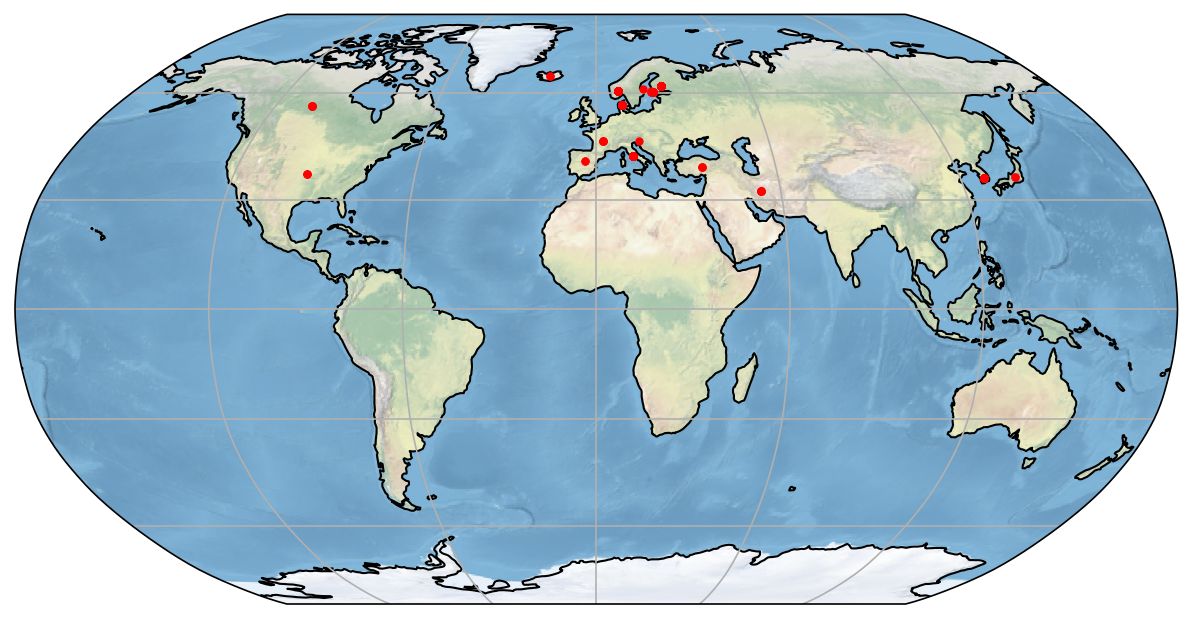

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10,7),dpi=150) # ouvre une fenêtre
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
plt.plot(long, lat,'.',
         color='red',
         transform=ccrs.PlateCarree(),
         )
plt.show()
#fig.savefig('map_isolats.png', dpi=fig.dpi) # sauve la figure

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>1.6 </b></font>A votre avis, s’agit-il d’un virus qui se reproduit dans les eaux chaudes ou plutôt dans les eaux froides?</p>

<font color="orange"><b>Eaux froides car nos isolats sont au nord de l'équateur et les eaux sont froides au nord</b></font>




## 2. Alignement des séquences protéiques pour pouvoir les comparer
Afin de comprendre comment le virus s’est propagé dans le monde, nous allons comparer les séquences protéiques des différents isolats. Ceci nous permettra de regrouper les isolats “les plus similaires” et nous ferons l’hypothèse vraisemblable qu’il ont une origine commune du fait de leur similarité.

Installation: Pour utiliser MUSCLE vous devez télécharger le fichier binaire (executable sans installation) depuis le [site (version 3)](https://drive5.com/muscle/downloads_v3.htm). 

Vous pouvez utiliser la version 5 en prenant la dernière release depuis le [dépot](https://github.com/rcedgar/muscle/releases/tag/v5.3) mais le code suivant est fait pour la version 3. Pour ceux sur un système UNIX ou assez de courage, vous pouvez tenter d'utiliser pyMUSCLE (voir [ici](https://github.com/althonos/pymuscle5)) qui utilise aussi la version 5 mais vous devrez aussi adapter le code. 

Pour comparer les séquences protéiques et voir à quel point elles diffèrent, il est nécessaire de commencer par les aligner. Vous allez apprendre à utiliser l’outil graphique Aliview pour aligner les séquences et les inspecter visuellement. Vous verrez par la suite comment réaliser ces mêmes opérations directement en python avec la librairie biopython, ce qui vous permettra d’automatiser le processus.

<b>→ Utilisez la liste de gi pour pouvoir générer un fichier fasta contenant toutes les séquences protéiques qui nous intéressent (pour rappel, notre requête initiale était: <font face='courier'>'G[gene] AND VHSV[orgn] NOT "mRNA"[title]"</font></b>


In [19]:
from Bio import SeqIO

protein_seq = Entrez.efetch(db="nucleotide",id=gi,rettype="fasta_cds_aa",retmode="text")
protein_seq = list(SeqIO.parse(protein_seq, "fasta"))

In [20]:
# Vérifier la longueur de la liste
print(len(protein_seq))

465


<b>→ Vous pouvez visualiser tous les éléments de <font face='courier'>protein_seq</font> </b>

In [21]:
# TBR - TRUCS
for i in range(len(protein_seq)):
    print('--> '+str(i))
    print(protein_seq[i])
    print('')

--> 0
ID: lcl|PP882718.1_prot_XBS26245.1_1
Name: lcl|PP882718.1_prot_XBS26245.1_1
Description: lcl|PP882718.1_prot_XBS26245.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26245.1] [location=1..1524] [gbkey=CDS]
Number of features: 0
Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSSCRKDSF...QMV')

--> 1
ID: lcl|PP882717.1_prot_XBS26244.1_1
Name: lcl|PP882717.1_prot_XBS26244.1_1
Description: lcl|PP882717.1_prot_XBS26244.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26244.1] [location=1..1524] [gbkey=CDS]
Number of features: 0
Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV')

--> 2
ID: lcl|PP882716.1_prot_XBS26243.1_1
Name: lcl|PP882716.1_prot_XBS26243.1_1
Description: lcl|PP882716.1_prot_XBS26243.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26243.1] [location=1..1524] [gbkey=CDS]
Number of features: 0
Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV')

--> 3
ID: lcl|PP882715.1_prot_XBS26242.1_1
Name: lcl|PP882715.1_prot_XBS26242.1_1


<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>2.1 </b></font>Recherchez dans <font face='courier'>protein_seq</font> les entrées avec l'identifiant KM244768. Pourquoi d'autres gènes apparaissent-ils dans notre liste si la requête initiale exigeait “G[gene]” ? Pourquoi avons-nous plus d'éléments (465 - état Mars 2025) dans notre liste de résultats alors que nous avions 410 (état mars 2025) identifiants GI ? (astuce: allez voir sur le site de Genbank l'entrée correspondant à l’identifiant KM244768).</p>

<font color="orange"><b>Je pense qu'il y a des autres gènes, parce qu'on regarde les isolats du virus. On a 465 au lieu de 410 car il y a 55 qui ont le gène != G. <br>Quand on regarde l'entrée correspondant à l'identifiant KM244768 on trouve: "Viral hemorrhagic septicemia virus isolate GH40 nucleoprotein (N), phosphoprotein (P), matrix protein (M), glycoprotein (G), non-virion protein (NV), and RNA-dependent RNA polymerase (L) genes, complete cds"<br>Les gènes qu'on voit sont N, P, M, G, NV et L --> donc il y a des gènes autres que G dans protein_seq
</b></font>

Avant de continuer, nous devons donc nous assurer que seules les séquences protéiques correspondant au gène G sont gardées.

<b>→ Faites une boucle pour tester le nom du gène</b>


In [22]:
print(len(protein_seq)) #pas dans le TP
updated_protein_seq = [ ps for i,ps in enumerate(protein_seq) if ps.description.find('gene=G')>0 ]
print(len(updated_protein_seq)) #pas dans le TP

# verify visually that only G genes are left
desc = [ps.description for i,ps in enumerate(updated_protein_seq)]
desc

465
410


['lcl|PP882718.1_prot_XBS26245.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26245.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882717.1_prot_XBS26244.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26244.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882716.1_prot_XBS26243.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26243.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882715.1_prot_XBS26242.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26242.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882714.1_prot_XBS26241.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26241.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882713.1_prot_XBS26240.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26240.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882712.1_prot_XBS26239.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26239.1] [location=1..1524] [gbkey=CDS]',
 'lcl|PP882711.1_prot_XBS26238.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26238.1] [location=1..1524] [gbkey=CDS]',
 'lcl|OQ

In [23]:
print(len(protein_seq))
print(len(updated_protein_seq))

465
410


<b>→ Maintenant que vous avez les séquences protéiques du gène G uniquement, remplacez l'id par le numéro d'accès et le nom du pays source (ceci facilitera les analyses par la suite).</b>

In [24]:
print(updated_protein_seq)

[SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSSCRKDSF...QMV'), id='lcl|PP882718.1_prot_XBS26245.1_1', name='lcl|PP882718.1_prot_XBS26245.1_1', description='lcl|PP882718.1_prot_XBS26245.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26245.1] [location=1..1524] [gbkey=CDS]', dbxrefs=[]), SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), id='lcl|PP882717.1_prot_XBS26244.1_1', name='lcl|PP882717.1_prot_XBS26244.1_1', description='lcl|PP882717.1_prot_XBS26244.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26244.1] [location=1..1524] [gbkey=CDS]', dbxrefs=[]), SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), id='lcl|PP882716.1_prot_XBS26243.1_1', name='lcl|PP882716.1_prot_XBS26243.1_1', description='lcl|PP882716.1_prot_XBS26243.1_1 [gene=G] [protein=glycoprotein] [protein_id=XBS26243.1] [location=1..1524] [gbkey=CDS]', dbxrefs=[]), SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPS

In [25]:
#si je ne veux pas avoir les séquences dont nous ne connaissons pas les pays ne pas les prendre à cette étape là...
#si country == NA ou nan ne pas mettre dans nos données update_protein_seq[]

for i,ps in enumerate(updated_protein_seq):
    access_number = ps.name.split('|')[1].split('_')[0]
    #print(str(i)+" "+country[i])
    country_tmp = country[i].replace(' ','-')
    updated_protein_seq[i].description = ''
    updated_protein_seq[i].id = access_number+'_'+country_tmp
    
updated_protein_seq

[SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSSCRKDSF...QMV'), id='PP882718.1_South-Korea', name='lcl|PP882718.1_prot_XBS26245.1_1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), id='PP882717.1_South-Korea', name='lcl|PP882717.1_prot_XBS26244.1_1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), id='PP882716.1_South-Korea', name='lcl|PP882716.1_prot_XBS26243.1_1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), id='PP882715.1_South-Korea', name='lcl|PP882715.1_prot_XBS26242.1_1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), id='PP882714.1_South-Korea', name='lcl|PP882714.1_prot_XBS26241.1_1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSNCRKDSF...QMV'), i

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>2.2 </b></font>
    Créer une nouvelle liste de protein_seqList à partir de updated_protein_seq mais sans les sequences dont le pays est inconnu</p>

In [33]:
updated_protein_seq[0].seq

Seq('MEWNTFFLVILVIIIKSTTSQITQRPPVENISTYHVDWDTPLYTHPSSCRKDSF...QMV')

In [43]:
# Votre code ...
#updated_protein_seq = []

protein_seqList = [ps for i, ps in enumerate(updated_protein_seq) if country[i].replace(' ','-') != 'NA']

In [47]:
#print(protein_seqList)

In [45]:
print(len(country))
print(len(name))
#print(updated_protein_seq)
print(len(updated_protein_seq))
print(len(protein_seqList))

410
410
410
322


<b>→ Créez un fichier FASTA avec ces séquences et ouvrez-le avec un éditeur de texte pour voir ce qu'il contient.</b>

In [46]:
output_handle = open('./data/labo-4_protein-sequences.fasta', 'w')
SeqIO.write(protein_seqList, output_handle, "fasta")
output_handle.close()

Installation de Aliview: https://ormbunkar.se/aliview/

<b>→ Sur votre ordinateur, lancez le programme Aliview et utilisez File > Open File pour ouvrir le fichier que vous venez de créer.</b> <br>
<b>→ Ou si vous n'avez pas le programme installer (version Java trop récente etc...)
Utiliser le programme Clustal Omega à l'ebi (https://www.ebi.ac.uk/jdispatcher/msa/clustalo)</b>

<b>→ Sur Aliview, allez sur Align > Realign everything et cliquez sur Ok.</b>

Par défaut, Aliview utilise l’algorithme MUSCLE pour aligner les séquences. 

<b>→ Avec l'outil que vous avez choisi, inspectez l’alignement visuellement et assurez-vous que tout semble normal.</b>

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>2.3 </b></font>Pourquoi est-ce que l'une des séquences est plus courte que les autres? Astuce: allez sur Genbank depuis votre navigateur pour voir l'entrée correspondant à la séquence très courte.
</p>


<font color="orange"><b>La séquence qui est plus courte que l'autre est la suivante: [FJ362514.1_Norway](https://www.ncbi.nlm.nih.gov/nuccore/FJ362514.1), c'est une séquence partielle (partial cds)</b></font>

Sur Aliview, il est possible d’enregistrer l’alignement: File > Save as Clustal (aln). Également avec Clustal Omega.<br>
Pour la suite du labo, nous allons générer ce même alignement à l’aide de la librairie biopython et faire quelques analyses sur cet alignement.

<font color="red"><b>Modifier ici car alignview est fonctionne avec une vielle version de java... Peut utiliser clustall omega sur ebi</b></font>

<b>→ Importez les modules suivants:</b>

In [48]:
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO

/home/tux/code/BBC_Labs/.venv/lib/python3.13/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


<b>→ Spécifiez le chemin vers votre exécutable muscle ou mettez le simplement dans le PATH pour windows</b>


In [49]:
# modifier si nécessaire

muscle_loc = r'/usr/bin/muscle' 
#muscle_loc = r"C:\Program Files\Muscle\muscle-win64.v5.3.exe"
#muscle_loc = r"C:\Program Files\Muscle\muscle3.8.31_i86win32.exe"

<b>→ Réalisez l’alignement à partir du fichier FASTA contenant les séquences</b>

In [74]:
# Séquences protéiques (FASTA)
in_file = os.path.join(r"/home/tux/code/BBC_Labs/Labo04/data/", r"labo-4_protein-sequences.fasta")
# Alignement des séquences protéiques (CLUSTAL)
out_file = os.path.join(os.getcwd(), r"data/output.aln")

# MUSCLE v3.8.31
muscle_cline = MuscleCommandline(muscle_loc, input=in_file, out=out_file, clwstrict=True)

In [75]:
print(len(protein_seqList))

322


In [ ]:
print(muscle_cline)

# Run MUSCLE
stdout, stderr = muscle_cline()
muscle_align = AlignIO.read(out_file,'clustal') # this command actually performs the alignment

print(muscle_align)

In [ ]:
muscle_align

<font color="orange"><b>Je n'ai pas réussi à faire le fichier avec du code, donc j'ai lancé `muscle -align labo-4_protein-sequences.fasta -output output.labo-4_protein-sequences.aln` à la place, pour générer le fichier</b></font>

Le fichier .aln généré peut être ouvert dans Jaliview pour l’inspecter visuellement.<br>
<b>Pour installer Jalview: https://www.jalview.org</b>

## 3. Construction de l’arbre phylogénétique et clustering hiérarchique pour identifier des groupes similaires
A partir de cet alignement, il est possible de générer un arbre phylogénétique. Par souci de temps, nous utiliserons FastTree qui est très rapide, même si cet outil n’est pas le mieux adapté pour construire un arbre phylogénétique à partir de séquences très proches comme c’est le cas ici. Vous pouvez trouver plus d'informations [ici](https://morgannprice.github.io/fasttree/). 

<b>→ Générez l’arbre avec FastTree</b>


In [79]:
from Bio.Phylo.Applications import FastTreeCommandline
import pylab

print(out_file)

/home/tux/code/BBC_Labs/Labo04/data/output.aln


In [80]:
# convert aln to phy format
out_phy = r'labo-4_protein-sequences.phy'
AlignIO.convert(out_file, 'clustal', out_phy, 'phylip-relaxed')

# generate the phylogenetic tree with FastTree
out_tree = r'labo-4_protein-sequences.tre'
cmd_fasttree =r"/home/tux/code/BBC_Labs/Labo04/FastTree"

ValueError: >KU728246.1_Denmark is not a known CLUSTAL header: CLUSTAL, PROBCONS, MUSCLE, MSAPROBS, Kalign, Biopython

In [78]:
fasttree_cmdline = FastTreeCommandline(cmd=cmd_fasttree,fastest=True,input=out_phy,out=out_tree)
print(fasttree_cmdline)
out_log, err_log = fasttree_cmdline()

# load tree
from Bio import Phylo
tree = Phylo.read('labo-4_protein-sequences.tre', 'newick')

Phylo.draw_ascii(tree)

NameError: name 'cmd_fasttree' is not defined

<b>→ Ouvrez le fichier <font face='courier'>labo-2_protein-sequences.tre</font> avec l'outil en ligne Phylogenetic tree (newick) viewer à cette adresse: http://etetoolkit.org/treeview/</b> <br>
Vous pouvez également utiliser dendroscope3 - http://ab.inf.uni-tuebingen.de/data/software/dendroscope3/download/welcome.html ou de iToL en ligne... https://itol.embl.de/
    
(dans TreeViewX et choisissez le mode de visualisation “phylogram” (bouton en haut à droite) et zoomez pour voir les groupes.)

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>3.1 </b></font>De quels pays vient l'isolat le plus proches des isolats de Corée du Sud?

<font color="orange"><b>Votre réponse...</b></font>

Combien de groupes voyez-vous? 
Ca dépend! Le nombre de groupes dépend du seuil utilisé pour admettre, ou non, que deux isolats font partie du même groupe. 

Afin de mieux visualiser la propagation du virus dans le monde, nous allons regrouper les séquences (i.e. les isolats) en 4 groupes et voir leur localisation géographique sur une carte du monde. Pour obtenir ces 4 groupes, nous allons commencer par calculer les distances (phylogénétiques) entre les isolats et réaliser un clustering hiérarchique à partir duquel nous obtiendrons 4 groupes.

<b>→ Calculez les distances entre les isolats</b> (ceci peut prendre un petit moment...)


In [ ]:
dmat = []
leaves = [str(cladit) for k,cladit in enumerate(tree.get_terminals())]
for l1,leave1 in enumerate(leaves):
    d = []
    for l2,leave2 in enumerate(leaves):
        d.append(tree.distance(leave1,leave2))
    dmat.append(d)

<b>→ Réalisez le clustering hiérarchique et visualisez le dendrogram obtenu (double-cliquez sur le graphique pour l'agrandir / ouvrez le séparément)</b>

In [ ]:
import scipy.cluster.hierarchy as cl
import scipy.spatial.distance as ssd

Z = cl.linkage(ssd.squareform(dmat),method='average',metric='euclidean')
print(Z.shape)
print(len(leaves))
fig = plt.figure(num=None,figsize=(60,15),dpi=250)
dendro=cl.dendrogram(Z,labels=leaves,color_threshold=0.06,leaf_rotation=90,leaf_font_size=9)
plt.show()

<b>→ Représentez les isolats de chaque groupe sur une carte du monde</b>

In [ ]:
print(name)
print(country)
print(updated_protein_seq)

In [ ]:
# On choisi 4 clusters de séquences proches

nb_clusters = 4
clusters = cl.fcluster(Z,nb_clusters,criterion='maxclust')

# Pour chaque cluster, on affiche les isolats correspondants sur une carte
for i in range(1,max(clusters)+1):

    # Index des élèments du cluster i
    idxi = [j for j,cluster in enumerate(clusters) if cluster==i]
    print(f"Idxi: {idxi}")
    
    lat_tmp = []
    lon_tmp = []
    
    # pour chaque élément du cluster i, on ajoute les coordonnées correspondantes. 
    for j,idxj in enumerate(idxi):
        access_number_of_leave = leaves[idxj].split('_')[0]
        #print(f"Access number of leave: {access_number_of_leave}")
        #print(f"Leaf: {leaves[idxj]}")
        #print(f"Index: {idxj}")
        lat_tmp.append(lat[j])
        lon_tmp.append(long[j])
    
    # plot
    fig = plt.figure(num=None,figsize=(7,6),dpi=150)   
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.gridlines()
    plt.plot(lon_tmp, lat_tmp,'.',
         color='red',
         transform=ccrs.PlateCarree(),
         )
    plt.show()
    fig.savefig('map_isolats-'+str(i)+'.jpg', dpi=fig.dpi)

Sur plusieurs de ces figures, vous pouvez voir que le virus “voyage” parfois même de très longues distances. L’une des raisons principales de cette propagation vient de l’échange d’oeufs et de larves de poissons contaminés entre pisciculteurs du monde entier (p.ex. entre l’Amérique du Nord et l’Asie).

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>3.2 </b></font>A l’aide du tableau ci-dessous, définissez le(s) genotype(s) probable auxquels appartiennent les 4 groupes identifiés. 
</p>

<i>Nota: Ces génotypes ont été définis en comparant les séquences des protéines G et N, alors qu’ici nous n’avons étudié que la protéine G.</i>

<table>

<tr>
<td><b>Type</b></td>
<td><b>Prevalent host type and location (source: <a href="https://en.wikipedia.org/wiki/Viral_hemorrhagic_septicemia">Wikipedia</a>)</b></td>
</tr>

<tr>
<td>I-a</td>
<td>Farmed rainbow trout and a few other freshwater fish in continental Europe</td>
</tr>

<tr>
<td>I-b</td>
<td>Marine fish of the Baltic Sea, Skagerrak, Kattegat, North Sea, Japan</td>
</tr>

<tr>
<td>I-c</td>
<td>Farmed rainbow trout Denmark</td>
</tr>

<tr>
<td>I-d</td>
<td>Farmed rainbow trout in Norway, Finland, Gulf of Bothnia</td>
</tr>

<tr>
<td>I-e</td>
<td>Rainbow trout in Georgia, farmed and wild turbot in the Black Sea</td>
</tr>

<tr>
<td>II</td>
<td>Marine fish of the Baltic Sea</td>
</tr>

<tr>
<td>III</td>
<td>Marine fish of the British Isles and northern France, farmed turbot in the UK and Ireland, and Greenland halibut (Reinhardtius hippoglossoides) in Greenland</td>
</tr>

<tr>
<td>IV-a</td>
<td>Marine fish of the Northwest Pacific (North America), North American north Atlantic coast, Japan, and Korea</td>
</tr>

<tr>
<td>IV-b</td>
<td>Freshwater fish in North American Great Lakes region</td>
</tr>

</table>

<font color="orange"><b>Votre réponse...</b></font>


## 4. Pour aller plus loin… L’épidémiologie

Les virus évoluent très rapidement à l’échelle de la vie humaine, et peuvent se propager rapidement à travers le monde. Un exemple de virus qui évolue très rapidement est la grippe saisonnière. Après chaque hiver, une grande partie de la population développe des anticorps contre la grippe de cette année et est donc immunisée… Mais comme le virus de la grippe évolue rapidement, l’année suivante, un nouveau mutant apparaît pour lequel la majorité de la population n’est pas complètement immunisée. Le vaccin basé sur la grippe de l’année précédente ne protège donc que partiellement la population, et est totalement inefficace dans les rares cas où un nouveau sous-type de grippe apparaît, créant un grand risque de pandémie.
La bioinformatique est très utile pour suivre l’évolution de la grippe et comprendre comment elle se propage.

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>4.1 </b></font>Par rapport à l’analyse faite ici, quel facteur important faudrait-il prendre en compte pour pouvoir identifier les “routes” empruntées par le virus pour se propager (i.e. “de où à où il va”)? (50 mots maximum)
</p>

<font color="orange"><b>Votre réponse...</b></font>

<p style="background-color:#2E7FD2;padding:3px; color:white;"><font size="4"><b>4.2 </b></font>Le [virus Zika](https://www.who.int/wer/2015/wer9045.pdf) a fait la une de l'actualité il y a quelque temps (2015). En effet, au Brésil, les autorités sanitaires locales ont observé une recrudescence de cas atteints du syndrome Guillain-Barré qui coincident avec des cas d'infections à virus Zika dans le grand public, ainsi qu’une augmentation du nombre de nouveau-nés atteints de microcéphalie dans le nord-est du pays [source: site OMS]. Répétez l'analyse de la Section 1 avec la requête <font face="courier">'zika virus[orgn] NOT "mRNA"[title]'</font>. Est-ce que le virus a été isolé et séquencé en Argentine (si oui, combien de fois)?
</p>

<font color="orange"><b>Votre réponse...</b></font>

In [ ]:
# Votre code

FIN DU LABORATOIRE!!